# Interactively validate a Convolutional Variational Autoencoder

The code in this nodebook is loading a pre-trained model and experiment with the encoder and decoder. 

In [ ]:
import sys
sys.path.append("..")

from settings import Config
sys.path.append(Config().values["conv_vae"]["code_dir"])

from sensorprocessing import sp_conv_vae

# print(Config().values)

# import argparse
# import json
# import re
# import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms
# from tqdm import tqdm

# these imports are from the Conv-VAE package
# import data_loader.data_loaders as module_data
# import model.loss as module_loss
# import model.metric as module_metric
# import model.model as module_arch
# from parse_config import ConfigParser
# from torch.nn import functional as F
# import torchvision.utils as vutils
from torchvision import transforms
# from torch.autograd import Variable
import os
import matplotlib.pyplot as plt
# import argparse
# import socket

# from mpl_toolkits.axes_grid1 import ImageGrid
#Fixes PosixPath Error
import pathlib

# Oh, this hack was fixing something, but for me it is the other way around
#temp = pathlib.PosixPath
#pathlib.PosixPath = pathlib.WindowsPath

In [2]:
from conv_vae import get_config, create_configured_vae_json, latest_model, latest_training_run

In [ ]:
sp = sp_conv_vae.ConvVaeSensorProcessing()
print(sp.model)
print(sp.model.encoder)
print(f"latent_dim {sp.model.latent_dim}")
# print(model.hidden_dims)

## Pass one picture through the complete autoencoder

Pass one specific picture through the complete autoencoder. Compare the input and the output. This is basically trying out whether the VAE had captured the picture sufficiently.

This code also is intended as a sample of how to use the pre-trained model, how to feed it new data without the training code. 

In [ ]:



# picture_name = '../../localdata/img/Rafael.jpg'
# picture_name = '../../localdata/img/indian-man.jpeg'
# picture_name = '../../localdata/img/00029_dev2.jpg'

# This is just a randomly chosen image from the training data. 

directory = pathlib.Path(Config().values["conv_vae"]["training_data_dir"], "Class-Folder")
print(directory)
files = list(directory.glob('*.jpg'))
picture_name = pathlib.Path(directory, files[11])


In [22]:
# Define a transform pipeline (e.g., converting to tensor)
# transform = transforms.ToTensor()
# image_size = 64
image_size = Config().values["robot"]["image_size"][0]

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
])


def load_image_to_tensor(picture_file, transform):
    """Loads an image from a file and transforms it into a single 
    element batch. Returns the batch and the image in a displayable format
    """
    # Load an image using PIL
    image = Image.open(picture_name)
    # print(image.mode)
    # FIXME: if this is already RGB, this is not needed
    # at least for the medical image, this is in 16 bit unsigned integer
    image_rgb = image.convert("RGB")
    # transform, scale, convert to tensor
    image_tensor = transform(image_rgb)
    # Display some information about the image tensor
    print(image_tensor.shape)  # e.g., torch.Size([3, H, W])
    # Convert the tensor to a format suitable for matplotlib (from [C, H, W] to [H, W, C])
    image_tensor_for_pic = image_tensor.permute(1, 2, 0)
    #plt.imshow(image_tensor_for_pic)
    # Add a batch dimension: shape becomes [1, 3, 224, 224]
    image_batch = image_tensor.unsqueeze(0)

    # Move tensor to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    image_batch_device = image_batch.to(device)
    return image_batch_device, image_tensor_for_pic


torch.Size([3, 64, 64])
mu = tensor([[-7.4926e-02,  1.1155e-01, -4.0424e-03, -2.6681e-01, -1.2714e-01,
          1.2389e+00, -1.2234e-01, -1.0425e-01, -2.3427e-01,  3.7719e-02,
         -9.1283e-03, -7.9103e-05,  6.8243e-02,  7.3793e-02,  1.2010e-01,
          7.8402e-02, -1.1418e-01,  1.5793e-01,  9.2162e-02,  1.3380e-01,
          2.5881e-01,  1.4024e-01, -4.8752e-02,  1.2938e-01,  8.1706e-01,
          1.4132e-02, -1.1986e-01, -8.7338e-02,  1.9995e-01, -5.5602e-02,
          5.9629e-02,  3.7405e-02,  4.5861e-01, -1.2054e-01,  1.0696e-01,
          3.8680e-01, -1.6452e-01, -5.2396e-02,  3.1002e-01, -4.7982e-01,
          1.3912e-01,  2.7758e-02, -1.8240e-02, -5.3050e-02, -1.2642e-01,
         -8.8088e-02, -4.9545e-01, -3.7993e-02, -1.7834e-01,  5.9628e-02,
          4.7551e-02, -6.7754e-01, -1.2370e-01,  8.1565e-01, -7.1953e-01,
          1.8360e-01, -3.8529e-01, -2.6165e-02,  1.5244e-01,  7.4256e-01,
         -3.3318e-02, -1.1226e-01,  1.2189e-02, -4.7470e-02, -3.2575e-01,
         

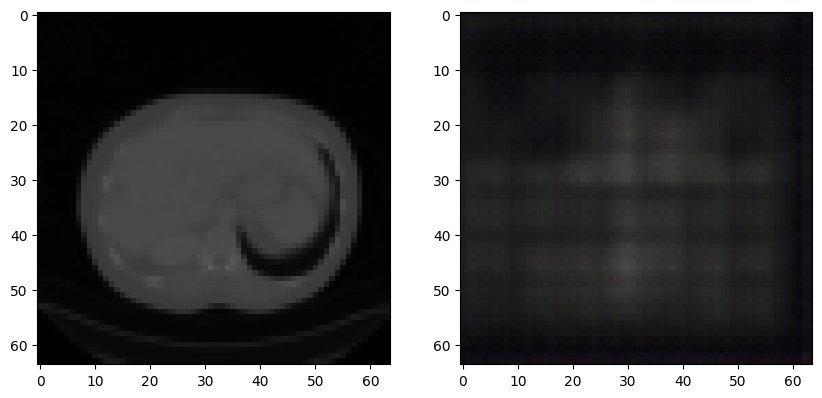

In [23]:
input, image = load_image_to_tensor(picture_name, transform)

# Running the input on the output
output, mu, logvar = sp.model(input)

# Output: the visual reconstruction
output_for_pic = output[0].cpu().permute(1, 2, 0).detach().numpy()

# mu: the encoding,
print(f"mu = {mu}")

# log_var: the log-var values for this input 
print(f"logvar = {logvar}")

# Showing the input and the reconstructed output side by side 
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(image)
axs[1].imshow(output_for_pic)


In [ ]:

# Try to do a decoding from the same mu
z2 = sp.model.reparameterize(mu, logvar)

for i in range(Config().values["robot"]["latent_encoding_size"]):
    z2[0][i] = z2[0][i] + 0.1

#z2[0][1] = 2.0
#z2[0][3] = 2.0
output2 = sp.model.decode(z2)
output_for_pic2 = output2[0].cpu().permute(1, 2, 0).detach().numpy()

# initial and new
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(output_for_pic)
axs[1].imshow(output_for_pic2)


# Generating random samples from the model

In [ ]:
import random

# z2 = model.reparameterize(mu, logvar)
# initial and new
fig, axs = plt.subplots(5, 5, figsize=(10, 5))
for x in range(0, 5):
    for y in range(0, 5):
            z2 = sp.model.reparameterize(mu, logvar)
            for i in range(Config().values["robot"]["latent_encoding_size"]):
                z2[0][i] += random.uniform(-0.5, 0.5)
            output2 = sp.model.decode(z2)
            output_for_pic2 = output2[0].cpu().permute(1, 2, 0).detach().numpy()
            axs[x][y].imshow(output_for_pic2)
#axs[0].imshow(output_for_pic)
#axs[1].imshow(output_for_pic2)